<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competition_1/blob/master/wrappers/duckietown_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Test image filters

In [1]:
import os 
if not os.path.isdir('gym-duckietown') or os.path.isdir('../gym-duckietown'):
  branch = "master" #@param ['master', 'daffy']
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if os.getcwd() != "/gym-duckietown":
  os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

Cloning into 'gym-duckietown'...
remote: Enumerating objects: 6116, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 6116 (delta 193), reused 314 (delta 137), pack-reused 5719
Receiving objects: 100% (6116/6116), 79.15 MiB | 30.26 MiB/s, done.
Resolving deltas: 100% (3502/3502), done.
Obtaining file:///content/gym-duckietown
     |████████████████████████████████| 220 kB 9.0 MB/s 
     |████████████████████████████████| 91 kB 10.6 MB/s 
  Created wheel for duckietown-slimremote: filename=duckietown_slimremote-2018.10.1-py3-none-any.whl size=1509 sha256=2d4faafb7ad71ad0e9558f3f391a44420efffd2bd010b096448e0f87645475e3
  Stored in directory: /root/.cache/pip/wheels/f5/24/a0/e823f95c258ab7a39694502907322cd09ee52d814ac7b860d9
  Created wheel for pygeometry: filename=PyGeometry-1.5.6-py3-none-any.whl size=68835 sha256=ca1b7c4b81ba5f897386e1f4d529ec2d9150d2dee3fc11a694539f11cc1db19f
  Stored in directory: /root/.cache/pip/w

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
map_name = "Duckietown-small_loop-v0" #@param ['Duckietown-straight_road-v0','Duckietown-4way-v0','Duckietown-udem1-v0','Duckietown-small_loop-v0','Duckietown-small_loop_cw-v0','Duckietown-zigzag_dists-v0','Duckietown-loop_obstacles-v0','Duckietown-loop_pedestrians-v0']

In [4]:
import cv2
import gym
from gym.spaces import Box

cutted_img_height = 480
resize_ratio = 0.5

img_height = 480
top_crop = img_height - cutted_img_height

img_final_height = int(cutted_img_height * resize_ratio)
img_final_width = int(640 * resize_ratio)

def cropimg(img):
    """
    Crop top of image top_crop px, they are noise most of the time

    :param img: (RGB image as np array) Image to be cropped
    """
    return img[top_crop:,:]

def houghtransform(img):
    """
    Apply Hough Line transform, for theory see:
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

    :param img: (RGB image as np array)
    """
    frame_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY, 3)
    edges = cv2.Canny(frame_BGR,50,150,apertureSize = 3)
    #minLineLength = 100
    #maxLineGap = 10
    #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    #for x1,y1,x2,y2 in lines[0]:
    #    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    imgRGB = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
    return imgRGB

def resizeimg(img, ratio):
    """
    Resize image
    :param img: (np array)
    :param ratio: (float) 0<ratio<1
    """
    return cv2.resize(img, (0,0), fx=ratio, fy=ratio) 
  
def takeyellow(img):
    """
    Extract yellow lines, for color ranges see:
    https://stackoverflow.com/questions/48109650/how-to-detect-two-different-colors-using-cv2-inrange-in-python-opencv

    :param img: (RGB image as np array)
    """
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    frame_threshold = cv2.inRange(frame_HSV, (20,100,100), (50, 255, 255))
    imgRGB = cv2.cvtColor(frame_threshold, cv2.COLOR_GRAY2RGB)
    return imgRGB

def takewhiteyellow(img):
    """
    Extract white and yellow lines

    :param img: (RGB image as np array)
    """
    #white
    sensitivity = 100
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskwhite = cv2.inRange(frame_HSV, lower_white, upper_white)
    img[maskwhite > 0] = (255, 0, 0)
    img[maskwhite == 0] = (0,0,0)
    #yellow
    maskyellow = cv2.inRange(frame_HSV, (15,70,70), (50, 255, 255))
    img[maskyellow > 0] = (0, 255, 0)
    return img

def white_balance(img):
    """
    Grayworld assumption:
    https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption/46391574

    :param img: (RGB image as np array)
    """
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

def kseniabirdeye(img):

    # original image dimensions
    width = img.shape[1]
    height = img.shape[0]

    # targeted rectangle on original image which needs to be transformed
    tl = [0, 0]
    tr = [width, 0]
    br = [width, height]
    bl = [0, height]

    corner_points_array = np.float32([tl,tr,br,bl])
    input_pts = corner_points_array

    # Create an array with the parameters (the dimensions) required to build the matrix
    pt_A = [0,0]
    pt_B = [width, 0]
    pt_C = [width*0.69, height]
    pt_D = [width*0.31, height]

    img_params = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = img_params
    # Compute and return the transformation matrix
    matrix = cv2.getPerspectiveTransform(input_pts, output_pts)
    return cv2.warpPerspective(img,matrix,(width, height), flags=cv2.INTER_LINEAR)

def birdeye(img, test=False):
    """
    Apply perspective transform to image, for theory see:
    https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html

    Also:
    https://stackoverflow.com/questions/48264861/birds-eye-view-opencv
    """
    if not test:
      black_wd = int(2500*resize_ratio)
      black_img = np.zeros(shape=(img.shape[0], black_wd, 3), dtype=np.uint8)
      x_offset=int((black_wd-img.shape[0])/2)
      black_img[:img.shape[0], x_offset:x_offset+img.shape[1]] = img
      img = black_img
    row, cols, ch = img.shape
    if test:
      src = np.float32([[90, 170], [620, 170], [0, 210], [720, 210]])
    else:
      src = np.float32([[int(1060*resize_ratio), int(170*resize_ratio)], [int(1060*resize_ratio), int(170*resize_ratio)], [int(110*resize_ratio), row], [cols, row]])
    dst = np.float32([[0,0],[640,0],[0,480],[640,480]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_transformed = cv2.warpPerspective(img, M, (cols, row))
    img_cutted_to_480_640 = img_transformed[:int(480*resize_ratio), :int(640*resize_ratio)]
    return img_cutted_to_480_640

class ObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ObsWrapper, self).__init__(env)
        self.observation_space = Box(0, 255, (img_final_height, img_final_width, 3), dtype=self.observation_space.dtype)
        # self.accept_start_angle_deg = 4
        self.env = env

    def observation(self, obs):
        # cropped = cropimg(obs)
        balanced = white_balance(obs)
        img = takewhiteyellow(balanced)
        resized = resizeimg(img, resize_ratio)
        bird = birdeye(resized)
        return bird

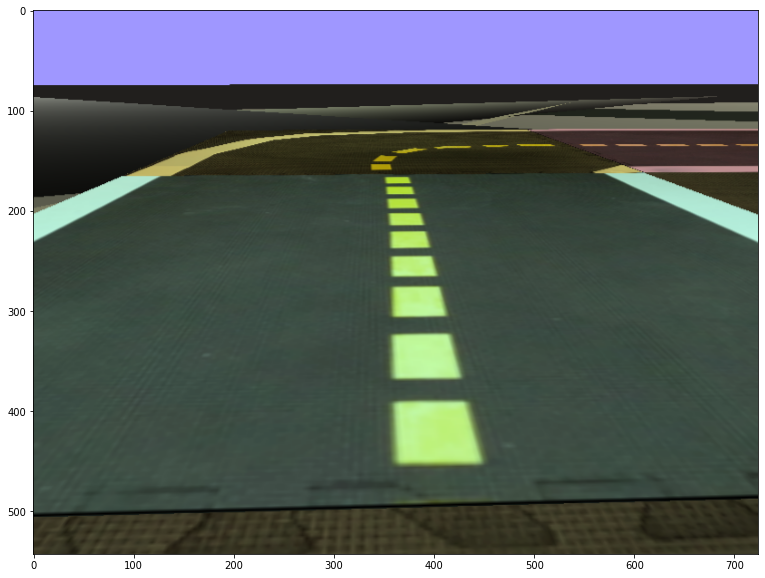

In [6]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://raw.githubusercontent.com/poliduckie/ReinforcementLearning/main/wrappers/perfect_road.png?token=AKSDDRG5IBMCY6X7375YDTDBT6VMQ")
try:
  test = Image.open(BytesIO(response.content))
except Exception:
  print("You have to get the image from github becuase of private folder etc")
  raise
test = test.convert('RGB')
plt.imshow(test)

In [7]:
test = np.array(test, dtype=np.uint8)

In [8]:
from copy import deepcopy
edit = deepcopy(test)

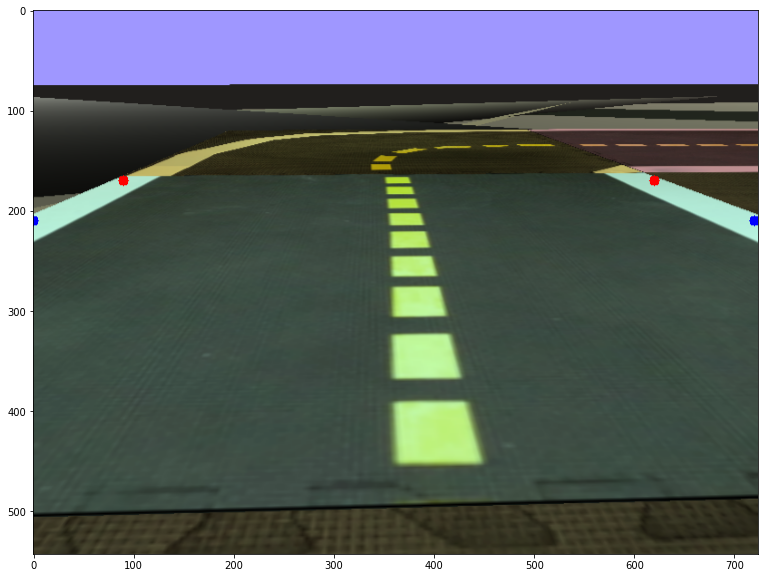

In [9]:
cv2.circle(edit, (90,170), radius=5, color=(255, 0, 0), thickness=-1)
cv2.circle(edit, (620,170), radius=5, color=(255, 0, 0), thickness=-1)
cv2.circle(edit, (0,210), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(edit, (720,210), radius=5, color=(0, 0, 255), thickness=-1)
plt.imshow(edit)

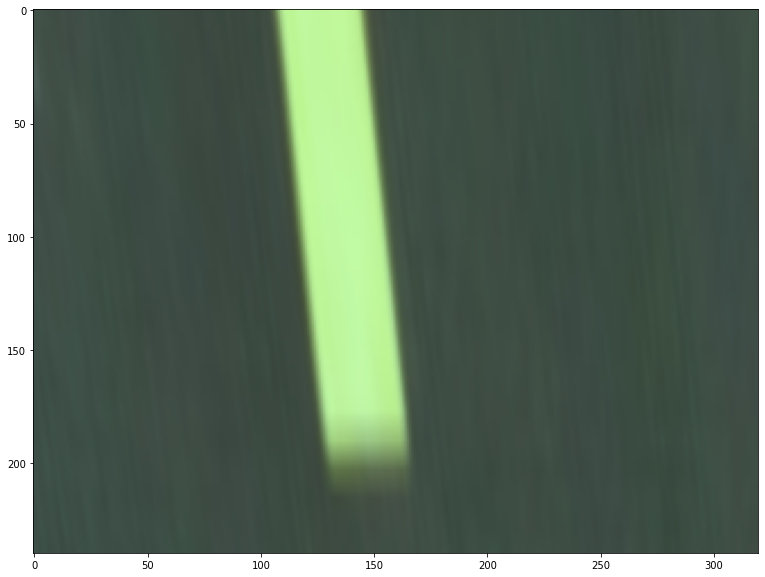

In [18]:
resized = resizeimg(edit, resize_ratio)
bird = birdeye(resized, test=True)
plt.imshow(bird)

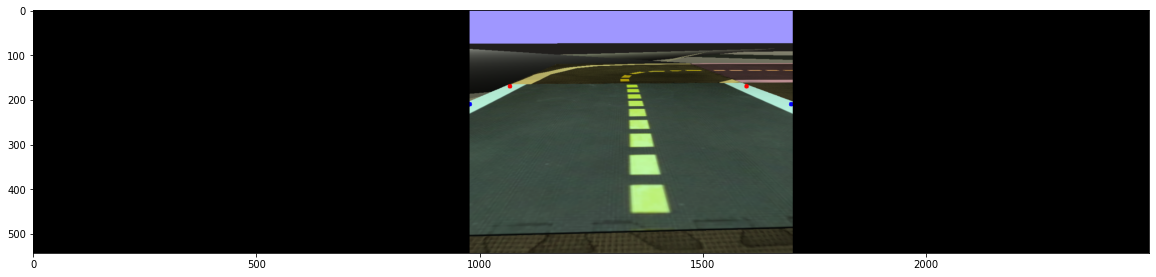

In [11]:
black_wd = 2500
black_img = np.zeros(shape=(edit.shape[0], black_wd, 3), dtype=np.uint8)
x_offset=int((black_wd-edit.shape[0])/2)
black_img[:edit.shape[0], x_offset:x_offset+edit.shape[1]] = edit
plt.imshow(black_img)

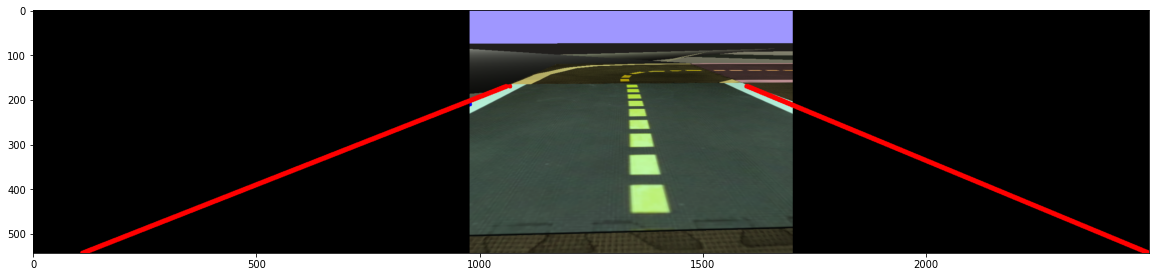

In [12]:
cv2.line(black_img, (1060, 170), (110, black_img.shape[0]), (255, 0, 0), thickness=10)
cv2.line(black_img, (1600, 170), (black_img.shape[1], black_img.shape[0]), (255, 0, 0), thickness=10)
plt.imshow(black_img)

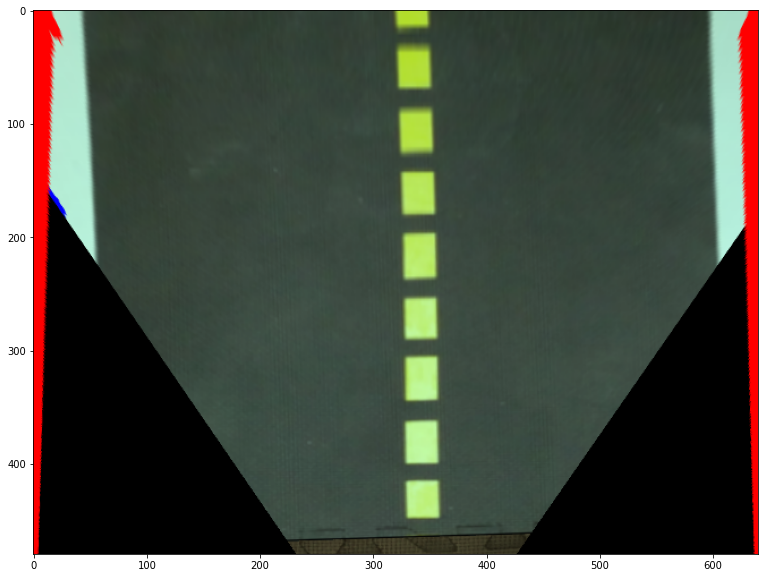

In [13]:
row, cols, ch = black_img.shape
src = np.float32([[1060, 170], [1600, 170], [110, row], [cols, row]])
dst = np.float32([[0,0],[640,0],[0,480],[640,480]])
M = cv2.getPerspectiveTransform(src, dst)
img_transformed = cv2.warpPerspective(black_img, M, (cols, row))
plt.imshow(img_transformed[:480, :640])

In [14]:
class BasicWrapper(gym.Wrapper):
    def __init__(self, env):
        super(BasicWrapper, self).__init__(env)
        self.env = env

    def reset(self):
        obs = self.env.reset()
        for _ in range(10):
          if (obs[:,:,1] == 255).any():
            break
          obs, reward, done, info = self.env.step([0, -1])
        return obs

In [15]:
import gym, gym_duckietown

display = Display(visible=0, size=(1400, 900))
display.start()

env = gym.make(map_name)
# env = BasicWrapper(env)
env = ObsWrapper(env)

ImportError: ignored

In [ ]:
obs = env.reset()
(obs[:,:,1] == 255).any()

In [ ]:
plt.imshow(obs)

In [ ]:
env.reset()

for i in range(10):

    lane_pose = env.get_lane_pos2(env.cur_pos, env.cur_angle)
    distance_to_road_center = lane_pose.dist
    angle_from_straight_in_rads = lane_pose.angle_rad
    
    k_p = 10
    k_d = 1
    speed = 0.5 
    steering = k_p*distance_to_road_center + k_d*angle_from_straight_in_rads
    
    obs, reward, done, info = env.step([speed, steering])
    plt.subplot(2, 2, 1)
    plt.imshow(obs)
    plt.subplot(2, 2, 2)
    plt.imshow(env.render(mode="rgb_array"))
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break
ipythondisplay.clear_output(wait=True)